# Exploratory Data Analysis (EDA)

Based on our inspection and analysis in this notebook we'll continue the next steps in the other notebooks corresponding the purpose of each one.
- Traditional ML Models `HDP-ML.ipynb`
- Artificial Neural Networks `HDP-ANN.ipynb`

### 1) Import Libraries

In [2]:
# Import libraries and modules

#----- Tools, visualizers -----
from scipy.stats import chi2_contingency, pointbiserialr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


### 2) Load Data and Inspect

In [3]:
#---------------
# Load dataset
#---------------
data = pd.read_csv("..\Data\heart-data.csv")
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [4]:
#-----------------
# Inspect & Info
#-----------------

# Get info and statistics
print(data.info())
print(data.describe().T)
print(20*"--")
# Check shape of the dataset
print(f"Shape of the dataset: {data.shape}")
# Count missing values
print(f"Counts of missing values:\n{data.isna().sum()}")
# Count duplicated values
print(f"Counts of duplicated values: {data.duplicated().sum()}")
# Check uniqueness of values
# Count unique values in each col
print(data.nunique())
# Get columns & their unique values
unique_values = {col: data[col].unique().tolist()
                  for col, value in zip(data.columns.tolist(), data.nunique()) if value <= 4}
unique_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
              count        mean         std   min     25%    50%    75%    max
Age           918.0   53.510893    9.432617  28.0   47.00   54.0   60.0   77.0
RestingBP     918.0  132.396514   18.51

{'Sex': ['M', 'F'],
 'ChestPainType': ['ATA', 'NAP', 'ASY', 'TA'],
 'FastingBS': [0, 1],
 'RestingECG': ['Normal', 'ST', 'LVH'],
 'ExerciseAngina': ['N', 'Y'],
 'ST_Slope': ['Up', 'Flat', 'Down'],
 'HeartDisease': [0, 1]}

### 3) Divide dataset by columns types

In [5]:
#---------------------------------------------------------------------------------
# Divide dataset into two different dataset 
# based on two types `Number` & `Object` and `Numeric` & `categorical` -> Only to check easily and quickly
#---------------------------------------------------------------------------------

# numerical features type (Only Continuous; So `FastingBS` & `HeartDisease` should be dropped)
num_cols = data.select_dtypes(include='number').drop(columns=['FastingBS', 'HeartDisease'], errors='ignore')
# Categorical features:  Object features type + `FastingBS`
obj_cols = data.select_dtypes(include='object')
cat_cols = pd.concat([obj_cols, data['FastingBS']], axis=1)
print(num_cols.head())
print(cat_cols.head())

   Age  RestingBP  Cholesterol  MaxHR  Oldpeak
0   40        140          289    172      0.0
1   49        160          180    156      1.0
2   37        130          283     98      0.0
3   48        138          214    108      1.5
4   54        150          195    122      0.0
  Sex ChestPainType RestingECG ExerciseAngina ST_Slope  FastingBS
0   M           ATA     Normal              N       Up          0
1   F           NAP     Normal              N     Flat          0
2   M           ATA         ST              N       Up          0
3   F           ASY     Normal              Y     Flat          0
4   M           NAP     Normal              N       Up          0


### Check impossible ranges and categorical values

When preparing data, it’s essential to validate whether values fall into *feasible ranges* and whether categorical features contain *unexpected values*. This step helps detect data entry errors, anomalies, or artifacts that could negatively affect the model.

- **Numeric features (impossible ranges):**  
  Certain columns have real-world physical or medical constraints. For example,  
  - Age should not be negative or unrealistically high (e.g., >120).  
  - RestingBP (resting blood pressure) cannot be zero or negative.  
  - Cholesterol cannot be zero (unless missing encoded badly).  
  - MaxHR (maximum heart rate) should not exceed 220 − age.  
  - Oldpeak (ST depression) should not be negative.  

  By checking these conditions, we can identify impossible or highly unlikely values.

- **Categorical features (unexpected values):**  
  For object/string features, we validate that categories belong to a known, limited set.  
  Example: "Sex" should only contain `M` or `F`. If we detect other categories (e.g., typos like `m`, `male`, `?`), they need to be handled.  

  This ensures categorical variables are clean and consistent, avoiding issues when encoding them later.


**In summary:**  
Checking ranges for numeric features prevents impossible values from biasing the model, while checking category distributions ensures data quality and avoids errors during preprocessing (like encoding).


### 4) Check labels (calsses) column distribution

HeartDisease
1    508
0    410
Name: count, dtype: int64


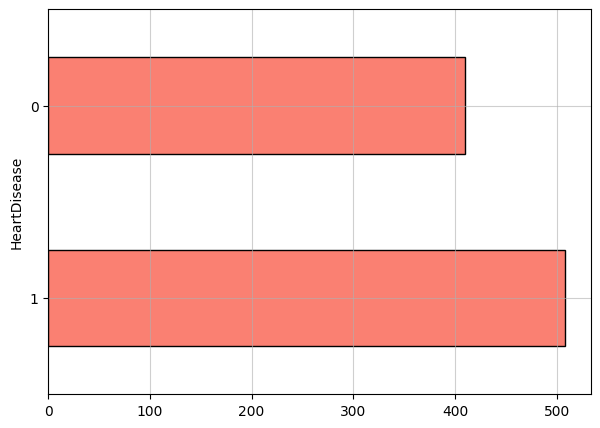

In [6]:
#-----------------------------------------
# Get the exact counts and visualize them
#-----------------------------------------

# Get the class column
target_col = data['HeartDisease'].value_counts()
# Adjust the plot
plt.figure(figsize=(7, 5))
target_col.plot.barh(color='salmon', edgecolor='k')
plt.grid(alpha=0.6)
# Print exact counts
print(target_col)

> The distribution of classes is fairly good and appropriate.

### 5) Check features columns distribution

In [7]:
#-------------------------------------
# Count values of categorical features 
#-------------------------------------

# Get object categorical features 
features = cat_cols
# Print each column's value counts
for f in features:
    print(data[f].value_counts())

Sex
M    725
F    193
Name: count, dtype: int64
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64
FastingBS
0    704
1    214
Name: count, dtype: int64


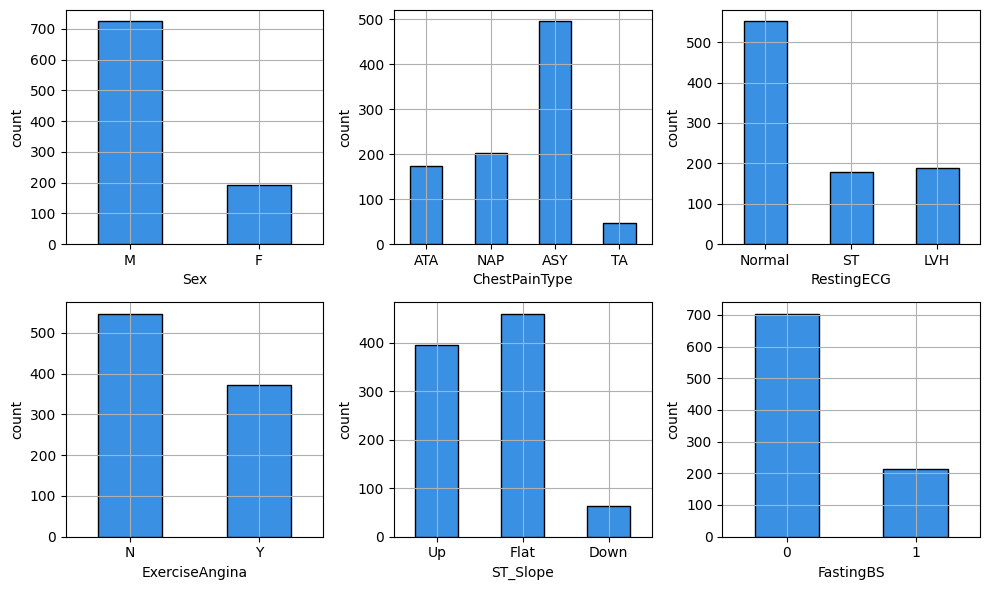

In [8]:
#-----------------------------------------
# Object features distribution using bars
#-----------------------------------------

# Create figure and its size/shape
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Flatten axes array for easy looping
axes = axes.flatten()

# Loop through the dataframe and get (index, column)
for i, col in enumerate(cat_cols):
    # Adjust the plot
    sns.countplot(x=col, data=cat_cols, ax=axes[i], width=0.5,
                   color='dodgerblue', edgecolor='black')
    # Add grids
    axes[i].grid()

# If there are empty subplots, remove them
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

> The distribution of object categorical features is sort of good; We can leave them as are, or do some feature engineering such as merging the rare features with similar ones just in case! 
- But We keep them as they are.

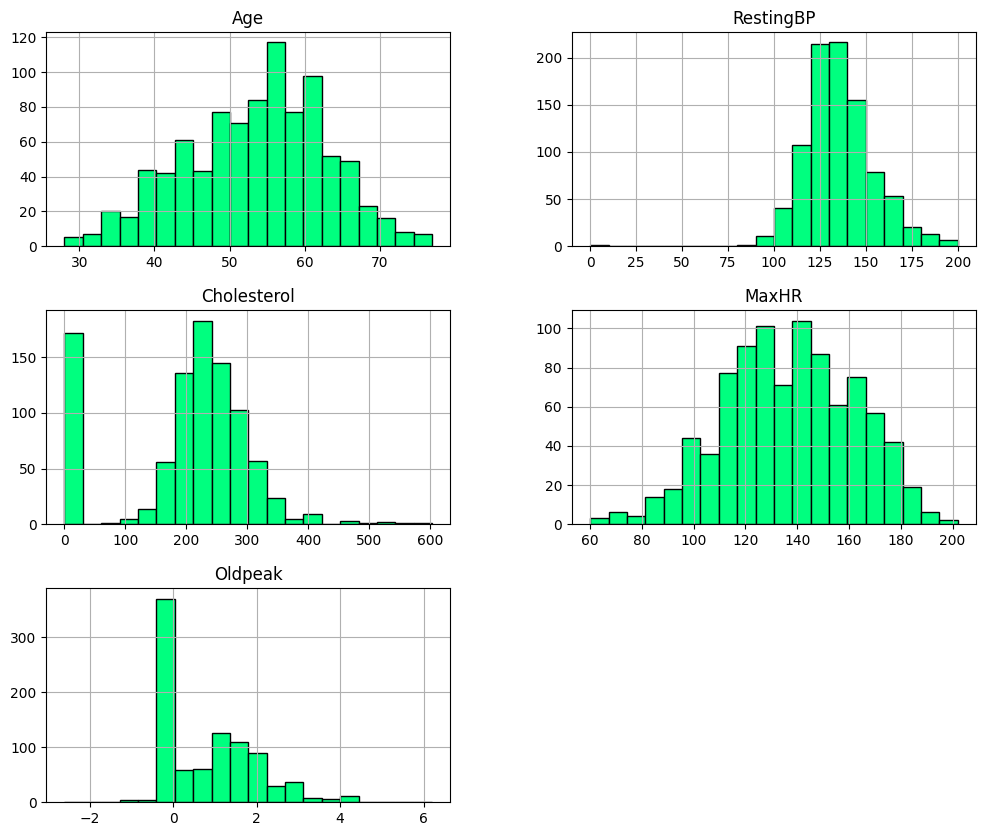

In [9]:
#------------------------------------------------------------
# Continuous numerical features distribution using Histogram
#------------------------------------------------------------

# Visualize features distribution
num_cols.hist(
    figsize=(12, 10), 
    color='springgreen',
    edgecolor='black',
    bins=20
)
plt.show()

> By looking at the histograms we can get a general idea of which numerical feature needs more inspection.
- Numerical Features need more inspections are as following:
    - RestingBP 
        - < 40 = unlikely (coma territory) | 250 <= extremely rare, maybe an error.
    - Cholesterol
        - < 80 = very suspicious | 700 <= probably measurement/entry error.
    - Oldpeak
        - range should be 0–6 | Negative values don’t make sense & 7–8 is very unlikely.

In [10]:
#---------------------------------------------------------------
# Check the features at hand further (Counts of unlikely values)
#---------------------------------------------------------------

#--RestingBP--
print('RestingBP:')
print(f"Counts of (< 40): {(num_cols['RestingBP'] < 40).sum()}",
        f"\nCounts of (>= 250): {(num_cols['RestingBP'] >= 250).sum()}\n{20*'--'}")

#--Cholesterol--
print('Cholesterol:')
print(f"Counts of (< 80): {(num_cols['Cholesterol'] < 80).sum()}",
        f"\nCounts of (>= 700): {(num_cols['Cholesterol'] >= 700).sum()}\n{20*'--'}")

#--Oldpeak--
print('Oldpeak:')
print(f"Counts of (< 0): {(num_cols['Oldpeak'] < 0).sum()}",
        f"\nCounts of (>= 7): {(num_cols['Oldpeak'] >= 7).sum()}")



RestingBP:
Counts of (< 40): 1 
Counts of (>= 250): 0
----------------------------------------
Cholesterol:
Counts of (< 80): 172 
Counts of (>= 700): 0
----------------------------------------
Oldpeak:
Counts of (< 0): 13 
Counts of (>= 7): 0


### 6) Check skewness and outliers of numerical features


**Threshold of skewness:**

- |skew| < 0.5 →  Almost symmetric → leave it as is

- 0.5 ≤ |skew| < 1 →  Moderate skew → consider transforming (if it matters for your model)

- |skew| ≥ 1 →  High skew → strongly consider transformation

> The following functions `skewness_detector` & `outliers_detector` for detecting skewness and outliers are also written in `utils.py` for usability.

In [11]:
#----------------
# Check skewness
#----------------
def skewness_detector(num_cols):
    # Compute skewness for each numerical features and add to dict
    sk = {col: abs(num_cols[col].skew()) for col in num_cols}
    # Convert to dataframe
    skewness = pd.DataFrame(sk, index=[0])
    # Melt (for better inspection)
    skewness = pd.melt(skewness, var_name='Feature', value_name='Skewness')
    # Check if skewness is exceeding the threshold (skewness >= 1)
    skewness['Exceeding_Threshold'] = skewness['Skewness'] >= 1
    return skewness

skewness_detector(num_cols)

,Feature,Skewness,Exceeding_Threshold
0,Age,0.195933,False
1,RestingBP,0.179839,False
2,Cholesterol,0.610086,False
3,MaxHR,0.144359,False
4,Oldpeak,1.022872,True


In [12]:
#-------------------------------------------
# Find potential outliers in numeric values
#-------------------------------------------

def outlier_detector(num_cols):
    # IQR method (1.5 * IQR) 
    outlier_info = [] 
    # Loop through numeric features
    for c in num_cols: 
        # Calculate Q1 -> 25%
        Q1 = num_cols[c].quantile(0.25) 
        # Calculate Q3 -> 75%
        Q3 = num_cols[c].quantile(0.75) 
        # Calculate IQR
        IQR = Q3 - Q1 
        # Calculate and determine lower and upper bounds
        lower = Q1 - 1.5 * IQR 
        upper = Q3 + 1.5 * IQR 
        # Filter outliers
        mask = (num_cols[c] < lower) | (num_cols[c] > upper) 
        # Count outliers
        n_out = mask.sum() 
        # Add all info to list (features, number of outliers, percentage of outliers)
        outlier_info.append((c, n_out, (n_out / len(num_cols) * 100).round(3)))

    # Convert to dataframe
    outlier_df = pd.DataFrame(outlier_info,
                            columns=['feature', 'n_outliers', 'outlier_pct']).sort_values('outlier_pct', ascending=False) 
    return outlier_df

outlier_detector(num_cols)


,feature,n_outliers,outlier_pct
2,Cholesterol,183,19.935
1,RestingBP,28,3.050
4,Oldpeak,16,1.743
3,MaxHR,2,0.218
0,Age,0,0.000


### 7) Check correlations of features and classes
- Numeric ↔ Numeric Correlations
- Categorical ↔ Categorical Correlations
- Feature ↔ Target Correlations
    - Continuous Numeric features ↔ Target
    - Categorical features ↔ Target

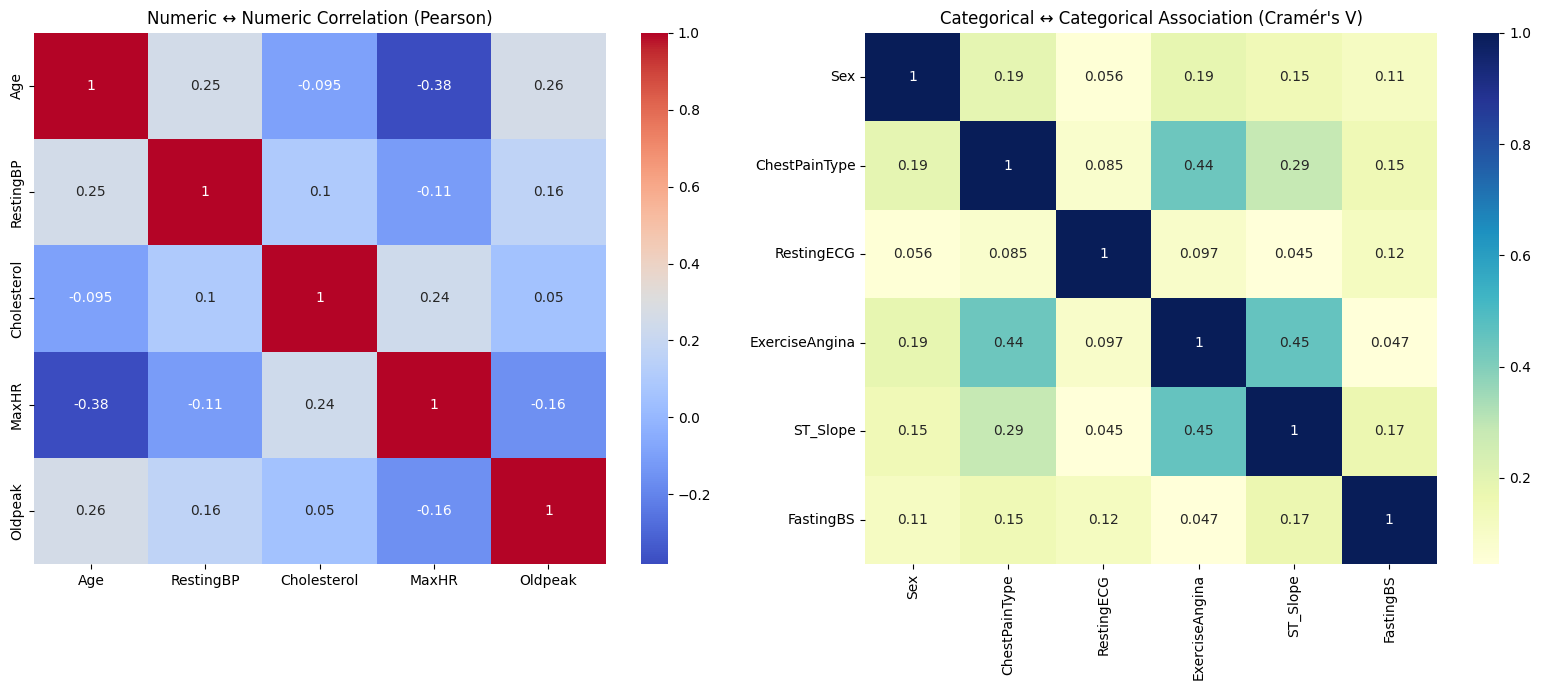

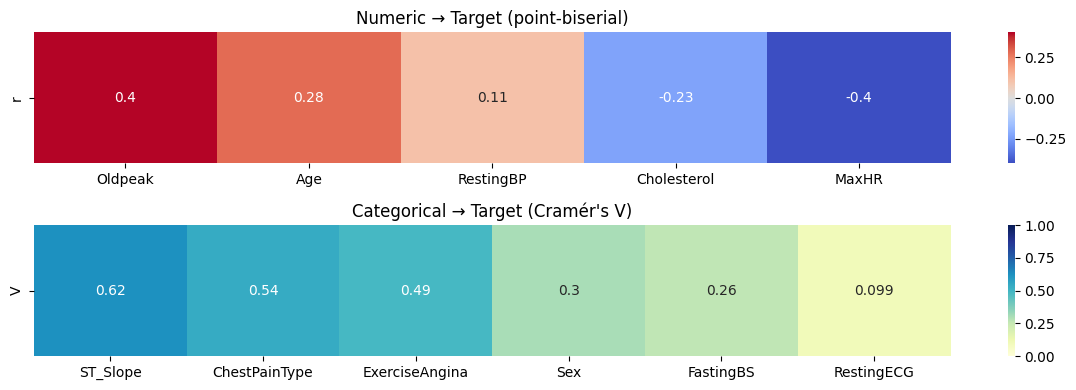

In [19]:
#-----------------------
# Correlation Analysis 
#-----------------------

# 1. Identify column types
# -----------------------------

# Get columns name as lists
numeric_features = num_cols.columns.tolist()
categorical_features = cat_cols.columns.tolist()

# 2. Create a figure for Pearson & Cramér's V heatmaps
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 3. Numeric ↔ Numeric (Pearson)
# -----------------------------

# Compute corrlations of numeric features
corr = data[numeric_features].corr(method='pearson')
# Adjust and Visualize
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Numeric ↔ Numeric Correlation (Pearson)")

# 3. Categorical ↔ Categorical (Cramér's V)
# -----------------------------

# Build up Cramér's V function to compute corrlations of categorical features
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Pairwise Cramér's V matrix and convert to dataframe
cramer_results = pd.DataFrame(index=categorical_features, columns=categorical_features)
for col1 in categorical_features:
    for col2 in categorical_features:
        cramer_results.loc[col1,col2] = cramers_v(data[col1], data[col2])

# Adjust and Visualize
sns.heatmap(cramer_results.astype(float), annot=True, cmap="YlGnBu", ax=axes[1])
axes[1].set_title("Categorical ↔ Categorical Association (Cramér's V)")

plt.tight_layout()
plt.show()

# 4. Feature ↔ Target
# -----------------------------

# Specify target column 
target_col = "HeartDisease" 

# Create a figure
fig, axes = plt.subplots(2, 1, figsize=(12, 4), gridspec_kw={'height_ratios':[1,1]})

# numeric → target (signed)
# Compute corrlations of numeric deatures and target
num_corr = {c: pointbiserialr(data[c], data[target_col])[0] for c in numeric_features}

# Convert to dataframe
num_df = pd.DataFrame.from_dict(num_corr, orient='index',
                                 columns=['r']).sort_values(by='r', ascending=False).T
# Adjust and Visualize
sns.heatmap(num_df, annot=True, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Numeric → Target (point-biserial)")

# categorical → target (Cramér's V)
# Compute corrlations of categorical features and target
cat_corr = {c: cramers_v(data[c], data[target_col]) for c in categorical_features}

# Covert to dataframe
cat_df = pd.DataFrame.from_dict(cat_corr, orient='index',
                                 columns=['V']).sort_values(by='V', ascending=False).T
# Adjust and Visualize
sns.heatmap(cat_df, annot=True, cmap="YlGnBu", vmin=0, vmax=1, ax=axes[1])
axes[1].set_title("Categorical → Target (Cramér's V)")

plt.tight_layout()
plt.show()

